In [ ]:
'''DESCRIPTION OF CODE:
    
This code is an implementation of a Long Short-Term Memory (LSTM) model for time series prediction using a sequence generator. 
Here's what the code does step by step:

1. Import necessary libraries including pandas, numpy, and keras.
2. Load dataset using pandas read_csv() function.
3. Normalize the data using the MinMaxScaler() function from sklearn.preprocessing.
4. Split the data into training and testing sets using the length of data and a pre-defined ratio (80:20 in this case).
5. Define a sequence_generator() function that generates sequences of input-output pairs (x,y) from the data, 
   where x is a sequence of data points with a specified length (seq_length) and y is the next data point after the sequence. 
   The function uses a stride to control how much overlap there is between sequences.
6. Build the LSTM model using keras Sequential() function. The model has two LSTM layers with 256 units each, followed by a 
   dense layer with 12 output nodes (one for each feature in the dataset). The model uses the mean squared error loss 
   function and the Adam optimizer with a learning rate of 0.001.
7. Train the model using the sequence_generator() function to generate batches of input-output pairs. 
   The number of steps per epoch is set to 100, and the model is trained for 10 epochs.
8. Evaluate the model performance on the test set. A new sequence generator is created for the test set, and the next 
   batch of data is used to predict the output. The predicted values are then inverted using the scaler object to get 
   the actual values and calculate the mean squared error (MSE) and root mean squared error (RMSE) for the test set.
'''

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import Adam

# Load dataset
df = pd.read_csv('iot_dataset.csv')

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# Split data into training and testing sets
train_size = int(len(scaled_data) * 0.80)
test_size = len(scaled_data) - train_size
train_data, test_data = scaled_data[0:train_size,:], scaled_data[train_size:len(scaled_data),:]

seq_length = 100

def sequence_generator(data, seq_length, batch_size, stride):
    num_samples = (len(data) - seq_length) // stride
    while True:
        indices = np.random.choice(num_samples, batch_size)
        x = np.zeros((batch_size, seq_length, 12))
        y = np.zeros((batch_size, 12))
        for i, idx in enumerate(indices):
            start_idx = idx * stride
            end_idx = start_idx + seq_length
            x[i,:,:] = data[start_idx:end_idx,:]
            y[i,:] = data[end_idx,:]
        yield x, y

model = Sequential()
model.add(LSTM(units=256, return_sequences=True, input_shape=(seq_length, 12)))
model.add(LSTM(units=256))
model.add(Dense(12))
model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.001))


# Train model using generator
batch_size = 128
stride = 10
train_generator = sequence_generator(train_data, seq_length, batch_size, stride)
steps_per_epoch = 100
model.fit(train_generator, epochs=10, steps_per_epoch=steps_per_epoch, verbose=1)

# Evaluate model
test_generator = sequence_generator(test_data, seq_length, batch_size, stride)
test_x, test_y = next(test_generator)
test_predict = model.predict(test_x)
test_predict = scaler.inverse_transform(test_predict)
test_y = scaler.inverse_transform(test_y)
test_mse = np.mean(np.square(test_predict - test_y))
print('Test Score: %.2f MSE (%.2f RMSE)' % (test_mse, np.sqrt(test_mse)))

# Make predictions
train_generator = sequence_generator(train_data, seq_length, batch_size, stride)
train_x, train_y = next(train_generator)
train_predict = model.predict(train_x)
train_predict = scaler.inverse_transform(train_predict)
train_y = scaler.inverse_transform(train_y)
test_generator = sequence_generator(test_data, seq_length, batch_size, stride)
test_x, test_y = next(test_generator)
test_predict = model.predict(test_x)
test_predict = scaler.inverse_transform(test_predict)
test_y = scaler.inverse_transform(test_y)

Epoch 1/10


C:\Users\13142\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


100/100 [==============================] - 119s 1s/step - loss: 0.0071
Epoch 2/10
100/100 [==============================] - 124s 1s/step - loss: 2.9370e-04
Epoch 3/10
100/100 [==============================] - 118s 1s/step - loss: 1.1937e-04
Epoch 4/10
100/100 [==============================] - 125s 1s/step - loss: 8.3762e-05
Epoch 5/10
100/100 [==============================] - 119s 1s/step - loss: 5.2495e-05
Epoch 6/10
100/100 [==============================] - 126s 1s/step - loss: 6.3175e-05
Epoch 7/10
100/100 [==============================] - 119s 1s/step - loss: 5.7063e-05
Epoch 8/10
100/100 [==============================] - 114s 1s/step - loss: 6.2804e-05
Epoch 9/10
100/100 [==============================] - 115s 1s/step - loss: 4.3395e-05
Epoch 10/10
4/4 [==============================] - 2s 246ms/step
Test Score: 1.17 MSE (1.08 RMSE)
4/4 [==============================] - 1s 288ms/step


In [3]:
from sklearn.metrics import r2_score

# Calculate R2 for test set predictions
r2 = r2_score(test_y, test_predict)
print(f"R2 score: {r2:.2f}")

R2 score: 0.89


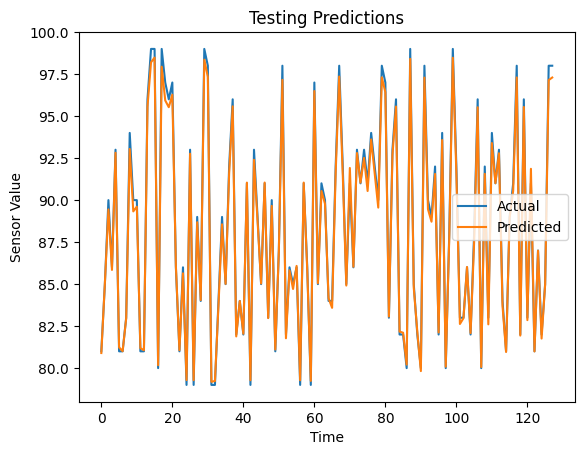

In [4]:
'''
This code is plotting the actual and predicted values of a sensor over time, using data that was processed and predicted 
using an LSTM neural network. The plot helps visualize how well the model performed in predicting the sensor values.
'''

import matplotlib.pyplot as plt

# Plot testing predictions
plt.plot(test_y[:,0], label='Actual')
plt.plot(test_predict[:,0], label='Predicted')
plt.title('Testing Predictions')
plt.xlabel('Time')
plt.ylabel('Sensor Value')
plt.legend()
plt.show()

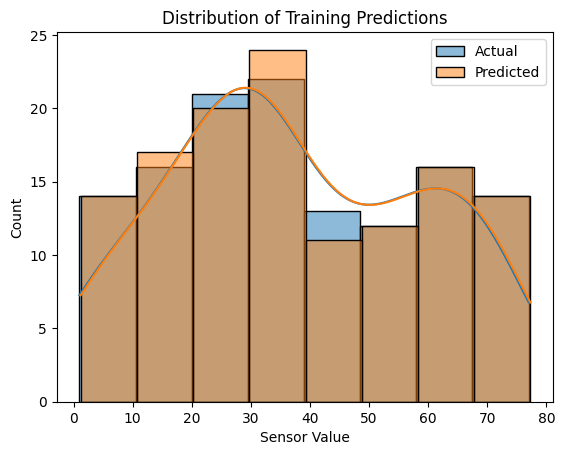

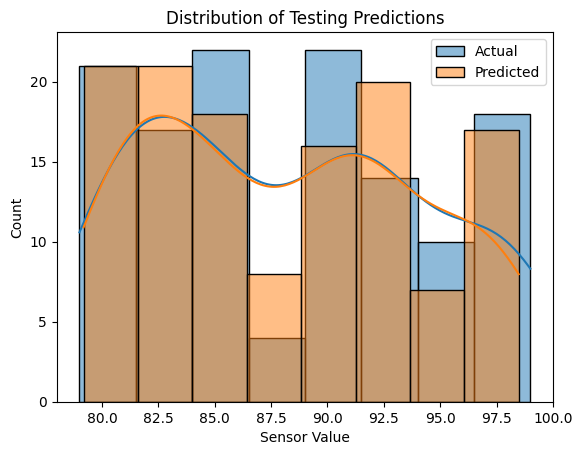

In [5]:
'''
This code is creating two histograms that compare the distribution of actual and predicted values for the training 
and testing sets. It uses the seaborn library to plot the histograms and includes a kernel density estimation (kde) plot 
to show the distribution of the data more clearly. The histograms give us an idea of how well the model is predicting the 
sensor values, as we can see how close the actual and predicted values are in terms of their distribution.
'''
import seaborn as sns

# Distribution of actual and predicted values for the training set
sns.histplot(train_y[:,0], label='Actual', kde=True)
sns.histplot(train_predict[:,0], label='Predicted', kde=True)
plt.title('Distribution of Training Predictions')
plt.xlabel('Sensor Value')
plt.ylabel('Count')
plt.legend()
plt.show()

# Distribution of actual and predicted values for the testing set
sns.histplot(test_y[:,0], label='Actual', kde=True)
sns.histplot(test_predict[:,0], label='Predicted', kde=True)
plt.title('Distribution of Testing Predictions')
plt.xlabel('Sensor Value')
plt.ylabel('Count')
plt.legend()
plt.show()